## setup and notebook configuration

In [1]:
# scientific python stack
import numpy as np
import sympy as sym
import orthopy
import quadpy
from scipy.interpolate import lagrange

In [2]:
# matplotlib, plotting setup
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns                       # nice plotting defaults
import cmocean as cmo                       # ocean colormaps
sym.init_printing(use_latex='mathjax')
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

/Users/corbin/virtual_envs/FEMexperiment_env/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [3]:
%load_ext autoreload
%autoreload 2

In [33]:
from src.fem_base.master.master_1D import Master1D
import src.fem_base.master.polynomials_1D as p1d
import src.fem_base.master.mk_master as mkm

# 1D nodal basis

We define the master 1D element as $I\in[-1, 1]$, so in this section we will develop the ideas behind building a 1D nodal basis on this interval.

## construction of vandermonde matrices

We will construct our nodal basis as a linear combination of orthonormal polynomials, namely, the Legendre polynomials, since they can be efficiently and stably computed. We use the open source library `orthopy` to generate the Jacobi polynomials as described in Hesthaven, Warburton.

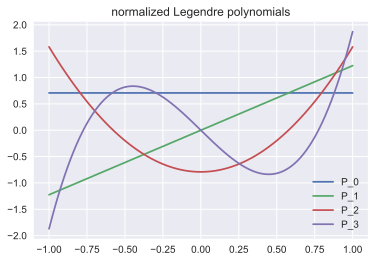

In [5]:
x = np.linspace(-1, 1, 100)
n_polys = 4
vals = orthopy.line_segment.tree_jacobi(x, n=n_polys, alpha=0, beta=0, standardization='normal')
for i in range(n_polys):
    plt.plot(x, vals[i], label='P_{}'.format(i))
plt.legend()

plt.title('normalized Legendre polynomials')
plt.show()

1. These polynomials form the 'modal' basis over [-1, 1], which we will connect to the nodal basis via the Vandermonde matrices described below.
2. The choice of an orthonormal (not simply orthogonal) basis provides some elegant ways of computing the mass and stiffness matrices.

We can create the Vandermonde matrix for the orthonormal modal basis in 1D. These functions can be found in `fem_base/master/polynomials_1D.py`.

In [6]:
# %load -s Jacobi_Poly,P_tilde,Vandermonde1D ../src/fem_base/master/polynomials_1D.py
def Jacobi_Poly(r, alpha, beta, N):
    """ wraps orthopy to return Jacobi polynomial
    @param r pts at which to evaluate the jacobi polynomial
    """
    return orthopy.line_segment.tree_jacobi(r, n=N-1,
        alpha=alpha, beta=beta, standardization='normal')

def P_tilde(r, N):
    P = np.zeros((len(r), N))
    polyvals = Jacobi_Poly(r, alpha=0, beta=0, N=N)
    for j in range(N):
        P[:, j] = polyvals[j]
    return P.T

def Vandermonde1D(N, x):
    """ initialize 1D vandermonde Matrix Vij = phi_j(x_i)"""
    V1D = np.zeros((len(x), N))
    JacobiP = Jacobi_Poly(x, alpha=0, beta=0, N=N)
    for j, polyvals in enumerate(JacobiP):
        V1D[:, j] = polyvals
    return V1D

An important conceptual point is that the Vandermonde matrix here is NOT the shape function matrix, it's the Vandermonde matrix of the Orthonormal polynomial basis. We will see this later as we have to create the shape function matrices.

Additionally, we wrap the `quadpy` library to create two interface functions, which generate Legendre Gauss Lobatto points and weights, as well as Gauss Legendre points and weights. 

In [7]:
# %load -s LegendreGaussLobatto,GaussLegendre ../src/fem_base/master/nodal_basis_1D.py
def LegendreGaussLobatto(N):
    """ generates N Legendre Gauss Lobatto points on [-1, 1]"""
    GL = quadpy.line_segment.GaussLobatto(N, a=0., b=0.)
    return GL.points, GL.weights

def GaussLegendre(N):
    """ generates N Gauss Legendre points on [-1, 1] """
    GL = quadpy.line_segment.GaussLegendre(N)
    return GL.points, GL.weights


## properties / conditioning of vandermonde matrices

The Vandermonde matrices associated with the modal Legendre basis are sensitive to choice of points at which the Vandermonde matrix is evaluated. This is discussed in Hesthaven.

- equidistant nodal points are very easy to generate, but lead to poorly conditioned Vandermonde matrices due to the well-known Runge phenomenon. 
- Legendre Gauss Lobatto points are more stable at high polynomial order. 

We can see how the determinant of the Vandermonde matrix grows as we move to a large number of nodal points (corresponding to high order polynomial order schemes).

In [8]:
equi_det, LGL_det = [], []
for N in range(2, 35):
    nb = N + 1
    equi_pts = np.linspace(-1, 1, nb)
    V = Vandermonde1D(nb, equi_pts)
    equi_det.append(np.linalg.det(V))
    
    LGL_pts, _ = LegendreGaussLobatto(nb)
    V = Vandermonde1D(nb, LGL_pts)
    LGL_det.append(np.linalg.det(V))

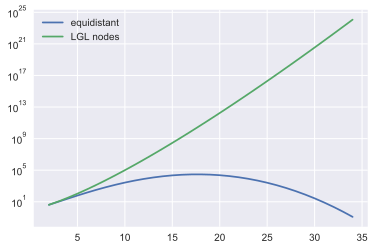

In [9]:
plt.semilogy(list(range(2, 35)), equi_det, label='equidistant')
plt.semilogy(list(range(2, 35)), LGL_det, label='LGL nodes')
plt.legend()
plt.show()

This plotted result agrees with that in Hesthaven. We wrap the scipy lagrange polynomial routines in order to construct a lagrange basis over the [-1, 1] interval for comparison.

### Runge phenomenon for lagrange polynomials

In the following subsection, we examine the Runge phenomenon of the lagrange polynomial basis when defined on equidistant points vs. LGL points. We will later develop the relations that allow us to build these nodal basis functions ("shape functions") over [-1, 1] from the Vandermonde matrices directly; but for now, we can explicitly create a lagrange basis of our choosing using `scipy` for the purposes of comparison.

In [10]:
# %load -s lagrange_polys,lagrange_basis_at_pts ../src/fem_base/master/polynomials_1D.py
def lagrange_polys(pts):
    lagrange_polys = []
    for i, pt in enumerate(pts):
        data = np.zeros_like(pts)
        data[i] = 1
        lagrange_polys.append(lagrange(pts, data))
    return lagrange_polys

def lagrange_basis_at_pts(lagrange_polys, eval_pts):
    """ evaluates lagrange polynomials at eval_pts"""
    result = np.zeros((len(lagrange_polys) ,len(eval_pts)))
    for i, poly in enumerate(lagrange_polys):
        result[i, :] = lagrange_polys[i](eval_pts)
    return result


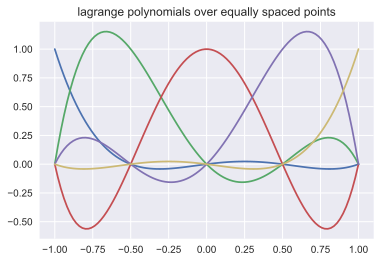

In [11]:
N = 5
lp = np.linspace(-1, 1, N)
lpolys = lagrange_polys(lp)

vN = 100
view_pts = np.linspace(-1, 1, vN)
li = lagrange_basis_at_pts(lpolys, view_pts)
plt.plot(view_pts, li.T)
plt.title('lagrange polynomials over equally spaced points')
plt.show()

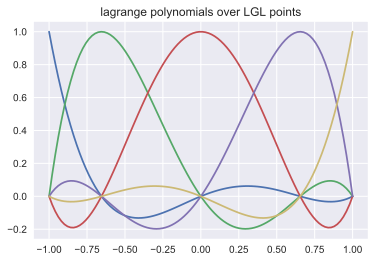

In [12]:
N = 5
lp, _ = LegendreGaussLobatto(N)
lpolys = lagrange_polys(lp)

vN = 100
view_pts = np.linspace(-1, 1, vN)
li = lagrange_basis_at_pts(lpolys, view_pts)
plt.plot(view_pts, li.T)
plt.title('lagrange polynomials over LGL points')
plt.show()

By choosing LGL points instead of equidistant points, our basis functions don't exceed 1, unlike in the above plot, where we are already seeing a slight Runge phenomenon, even at low order. We will later see that these effects are exaggerated when computing the derivatives of these nodal shape functions.

## vandermonde relations

### relationship between vandermonde $V$, orthonormal modal basis polynomials $\tilde{\mathbf{P}}$, and lagrange basis functions (shape functions) $\ell$

Hesthaven makes the claim that $V^T \mathbf{\ell}(r) = \tilde{\mathbf{P}}(r)$ in (3.3).

In Hesthaven's notation, $N$ denotes the polynomial order, $N_p$ denotes the number of nodal points (we would call $nb$), and let's call the number of "view points" `xx`, which are arbitrary.

Then the shapes of the Hesthaven structures are:
- $\mathbf{\ell}$, $\tilde{\mathbf{P}}$, $V$ are all (`nb`, `xx`)
- $V^T \ell$ is (`xx`, `nb`) x (`nb`, `xx`) $\rightarrow$ (`xx`, `xx`) where rows contain the values of polynomials $\tilde{\mathbf{P}}$

This works for either equidistant points or the LGL points. So in this case we start from the lagrange basis, and compute the orthonormal modal coefficients. This has important applications when we have a nodal solution, but would like to decompose the solution into its modal components for spectral analysis or filtering.

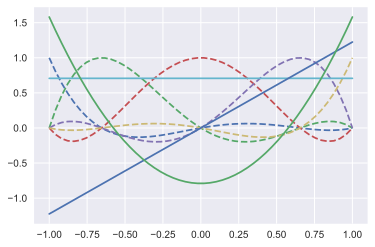

In [13]:
N = 5
lp, _ = LegendreGaussLobatto(N)  # LGL points
#lp = np.linspace(-1, 1, N)      # Equidistant points
view_pts = np.linspace(-1, 1, 50)

l_polys = lagrange_polys(pts=lp)
ℓ = lagrange_basis_at_pts(l_polys, eval_pts=view_pts)
V = Vandermonde1D(N=len(view_pts), x=lp)
P = np.dot(V.T, ℓ)

# plot the result
plt.plot(view_pts, ℓ.T, '--')
plt.plot(view_pts, P[0:3,:].T)
plt.show()

We see that indeed we recover the orthonormal Legendre polynomials. 

Going the other way, we can invert the relation to find that

$$\ell = (V^T)^{-1} \tilde{\mathbf{P}}$$

which allows us to create our nodal shape functions from the orthonormal modal polynomial coefficients. 

shape of Vandermonde: (4, 4)
shape of P: (4, 50)


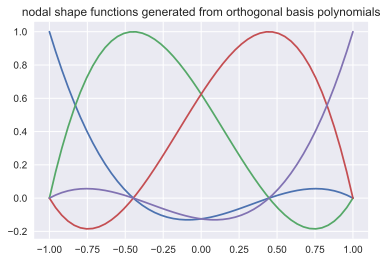

In [14]:
nb = 4
nodal_pts, _ = LegendreGaussLobatto(nb)
view_pts = np.linspace(-1, 1, 50)

# create the Vandermonde, P matrices
V = Vandermonde1D(N=nb, x=nodal_pts)
Vti = np.linalg.inv(V.T)
P = P_tilde(r=view_pts, N=nb)
print('shape of Vandermonde: {}'.format(V.shape))
print('shape of P: {}'.format(P.shape))

yy = np.dot(Vti, P)
plt.plot(view_pts, yy.T)
plt.title('nodal shape functions generated from orthogonal basis polynomials')
plt.show()

This is how we can efficiently evaluate the nodal shape functions at arbitrary points on the master element. This will be important for generating the data structures used for mapping and quadrature on the master element.

### relationship between vandermonde $V$ and mass matrix

We can build on the relationship developed in the section above to form the mass matrix for a nodal basis. We note that 

$M_{ij} = \int_{-1}^{1}\ell_i(r)\, \ell_j(r) \,dr = (\ell_i, \ell_j)_I$, and if we expand out $\ell = (V^T)^{-1}\tilde{\mathbf{P}}$, it turns out (page 51)

$$M = (V V^T)^{-1}$$

because of the orthogonal nature of our choice of basis function; the implication is that we can compute the integrals over the master element without the explicit need for quadrature points or weights. Note first that $\phi_i(\xi) = \sum_{n=1}^{nb} (V^T)_{in}^{-1} \tilde{P}_{n-1}(\xi)$. Then

\begin{align}
M_{ij} &= \int^{1}_{-1} \phi_i(\xi)\,\phi_j(\xi)\,d\xi 
      = \int^{1}_{-1}\left[\sum_{k=1}^{nb} (V^T)_{ik}^{-1} \tilde{P}_{k-1}(\xi)
      \sum_{m=1}^{nb} (V^T)_{jm}^{-1} \tilde{P}_{m-1}(\xi) \right]\, d\xi \\
      &= \sum_{k=1}^{nb} \sum_{m=1}^{nb} (V^T)_{ik}^{-1} 
       (V^T)_{jm}^{-1} \int^{1}_{-1}\tilde{P}_{k-1}(\xi) \tilde{P}_{m-1}(\xi)
       =\sum_{k=1}^{nb} \sum_{m=1}^{nb} (V^T)_{ik}^{-1}
       (V^T)_{jm}^{-1} \delta_{km} \\
       &=\sum_{k=1}^{nb} (V^T)_{im}^{-1} 
       (V^T)_{jm}^{-1} = \sum_{k=1}^{nb} (V^T)_{mi}^{-1} (V)_{mj}^{-1} \\
       &= (V^{T})^{-1} V^{-1} = (VV^T)^{-1}
\end{align}

Where note we've used the cute trick that $\int_{-1}^1 \tilde{P}_m \tilde{P}_n = \delta_{mn}$, since we chose an __orthonormal__ modal basis. Orthogonal wouldn't have done it, but an orthonormal modal basis has this property.

We can check this relation against the more traditional way of constructing the mass matrix with quadrature. `master.shap` has dimensions of (`n_quad`, `nb`)

In [15]:
order = 3
m1d = Master1D(p=order)
M_quadrature = m1d.M

Np = order + 1
nodal_points, _ = LegendreGaussLobatto(Np)
V = Vandermonde1D(N=Np, x=nodal_points)
M_vand = np.linalg.inv(np.dot(V, V.T))

# throw error if mass matrices created by quadrature / Hesthaven relation unequal
assert(np.allclose(M_quadrature, M_vand))

## efficient computation of derivatives of the basis functions

### derivatives of Legendre polynomials

In order to compute the derivatives of the shape functions (which are expressed via the vandermonde matrix $V$), we must take the derivatives with respect to the orthogonal basis polynomials. There is an identity (Hesthaven, p. 52)

$$ \frac{d \tilde{P}_n}{d r} = \sqrt{n(n+1)}\,\tilde{P}^{(1,1)}_{n-1}$$

This is in contrast to directly differentiating either the coefficients of $\tilde{P}$ or more directly the nodal shape functions $\ell$ if the explicit polynomial form is known (like in `scipy`, but this becomes trickier in multiple dimensions). As it turns out, the first approach is a very efficient way to compute these operators.

In [16]:
def Jacobi_Poly_Derivative(r, alpha, beta, N):
    """ take a derivative of Jacobi Poly, more general than above
    copy the format of orthopy (list of arrays)
    """
    dp = [np.zeros_like(r)]
    Jacobi_P = Jacobi_Poly(r, alpha + 1, beta + 1, N)
    for n in range(1, N+1):
        gamma = np.sqrt(n * (n + alpha + beta + 1))
        dp.append(gamma * Jacobi_P[n-1])
    return dp

#def dP_tilde(r, N):
#    P = np.zeros((len(r), N))
#    polyvals = Jacobi_Poly_Derivative(r, alpha=0, beta=0, N=N)
#    for j in range(N):
#        P[:, j] = polyvals[j]
#    return P

We can examine some of the derivatives of the Legendre polynomials. 

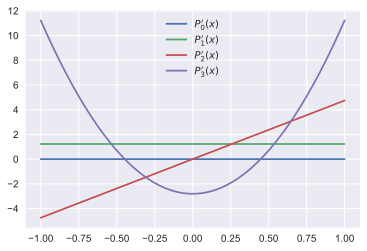

In [17]:
xx = np.linspace(-1, 1, 50)
jpd = Jacobi_Poly_Derivative(xx, alpha=0, beta=0, N=3)
for i, polyder in enumerate(jpd):
    plt.plot(xx, polyder, label=r'$P_{}^\prime(x)$'.format(i))
plt.legend()
plt.show()

These look good. The derivative of the first Legendre polynomial is analytically $P_0^\prime=0$, $P_1^\prime = \sqrt{3/2}$, $P_2^\prime$ should be linear, $P_3^\prime$ should be quadratic, etc.

### discrete derivative operators

We can declare the derivative Vandermonde matrix, and invert it in the same manner to obtain the derivatives of the nodal shape functions.

This works because 
$$V^T \ell = P \Rightarrow V^T \frac{d}{dx} \ell = \frac{d}{dx}P$$

Hence $$V_r\equiv V^T D_r^T, \qquad {V_r}_{(ij)} = \frac{d \tilde{P}_j(r_i)}{d x} $$

and finally $D_r = V_r V^{-1}$ (see Hesthaven, p. 53), as well as $S = M D_r $, where $S_{ij} = \left(\phi_i, \frac{d\phi_j}{dx}\right)_I$, and where $M$ is the mass matrix.

In [18]:
def GradVandermonde1D(N, x):
    Vr = np.zeros((len(x), N))
    dJacobi_P = Jacobi_Poly_Derivative(x, alpha=0, beta=0, N=N-1)
    for j, polyder in enumerate(dJacobi_P):
        Vr[:,j] = polyder
    return Vr

shape Vr:    (50, 4)
shape V inv: (4, 4)
shape Dr:    (50, 4)


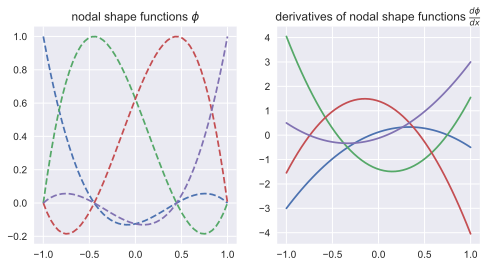

In [19]:
p = 3
nb = p+1
nodal_pts, _ = LegendreGaussLobatto(nb)
#nodal_pts = np.linspace(-1, 1, nb)
view_pts = np.linspace(-1, 1, 50)

# grad vandermonde
V  = Vandermonde1D(N=nb, x=nodal_pts)
Vr = GradVandermonde1D(N=nb, x=view_pts)
Vi = np.linalg.inv(V)
Dr = np.dot(Vr, Vi)

print('shape Vr:    {}'.format(Vr.shape))
print('shape V inv: {}'.format(Vi.shape))
print('shape Dr:    {}'.format(Dr.shape))

# shape functions
V = Vandermonde1D(N=nb, x=nodal_pts)
Vti = np.linalg.inv(V.T)
P = P_tilde(r=view_pts, N=nb)
shap = np.dot(Vti, P)

# shape functions at view points
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(view_pts, shap.T, '--')
ax[0].set_title(r'nodal shape functions $\phi$')
ax[1].plot(view_pts, Dr)
ax[1].set_title(r'derivatives of nodal shape functions $\frac{d \phi}{dx}$')
plt.show()

As a remark, we can once again show the effect of using Legendre Gauss Lobatto points vs equally spaced nodal points.

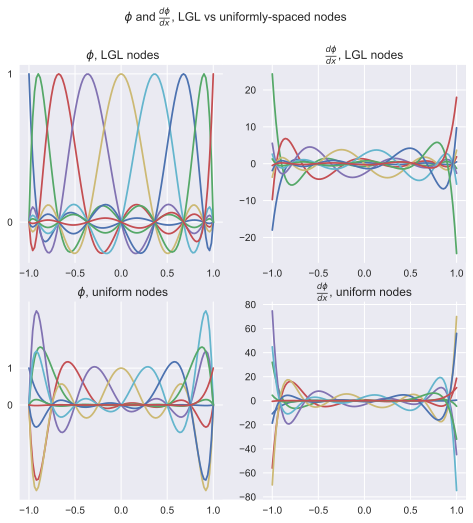

In [20]:
N = 8
nb = N+1
nodal_pts_LGL, _ = LegendreGaussLobatto(nb)
nodal_pts_equi = np.linspace(-1, 1, nb)
view_pts = np.linspace(-1, 1, 100)

# shape functions at view points
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yticks([])
ax.set_xticks([])
labels = ['LGL nodes', 'uniform nodes']
for idx, nodal_pts in enumerate([nodal_pts_LGL, nodal_pts_equi]):
    # grad vandermonde
    V  = Vandermonde1D(N=nb, x=nodal_pts)
    Vr = GradVandermonde1D(N=nb, x=view_pts)
    Vi = np.linalg.inv(V)
    Dr = np.dot(Vr, Vi)

    # shape functions
    V = Vandermonde1D(N=nb, x=nodal_pts)
    Vti = np.linalg.inv(V.T)
    P = P_tilde(r=view_pts, N=nb)
    shap = np.dot(Vti, P)
    
    # plot
    ax = fig.add_subplot(2, 2, idx*2+1)
    ax.plot(view_pts, shap.T)
    ax.set_yticks([0, 1])
    ax.set_title(r' $\phi$, {}'.format(labels[idx]))
    ax = fig.add_subplot(2, 2, idx*2+2)
    ax.plot(view_pts, Dr)
    ax.set_title(r'$\f{}$, {}'.format('rac{d \phi}{dx}',labels[idx]))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
fig.suptitle(r'$\phi$ and $\frac{d\phi}{d x}$, LGL vs uniformly-spaced nodes')
plt.show()

### remarks on discrete derivative operators

Suppose we compute the derivative matrix $D_r$ at the nodal points for some order $p$. There are some interesting properties to understand about these derivative matrices.

#### annihilation of constant vectors

Note that if we represent a function nodally, i.e., $u = c_i \phi_i(x)$, then

$$ \frac{du}{dx} = \frac{d}{dx}(c_i \phi_i(x)) = c_i \frac{d\phi_i}{dx} $$

Therefore, if we want to discretely take a derivative of a function (we'll represent the function on the master element for now, but trivially, we could map it to some other region), it suffices to multiply the derivative operator with the nodal vector $D_r u$. It should be clear, then, that $D_r$ will annihilate any constant vector.

In [21]:
p = 2
nb = p+1
nodal_pts, _ = LegendreGaussLobatto(nb)
u = np.ones_like(nodal_pts)

# grad vandermonde
V  = Vandermonde1D(N=nb, x=nodal_pts)
Vr = GradVandermonde1D(N=nb, x=nodal_pts)
Vi = np.linalg.inv(V)
Dr = np.dot(Vr, Vi)

duh = np.dot(Dr, u)
print(np.max(np.abs(duh)))

1.1102230246251565e-16


#### exponential convergence in $p$ for smooth functions

If the function of which we are attempting to take the discrete derivative is smooth (in the sense of infinitely differentiable), then we will see exponential convergence to the analytical solution w/r/t polynomial order of the nodal basis.

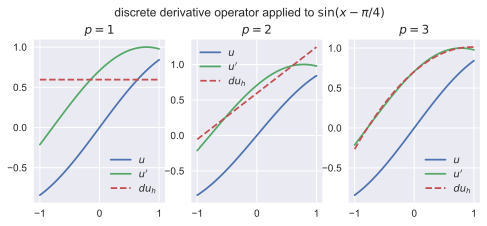

In [22]:
ps = [1, 2, 3, 4, 8, 12, 16, 18, 24, 32]
errs = []
fig, ax = plt.subplots(1, 3, figsize=(8, 3))
for p in ps:
    nb = p+1
    nodal_pts, _ = LegendreGaussLobatto(nb)
    view_pts = np.linspace(-1, 1, 100)

    # grad vandermonde
    V  = Vandermonde1D(N=nb, x=nodal_pts)
    Vr = GradVandermonde1D(N=nb, x=nodal_pts)
    Vi = np.linalg.inv(V)
    Dr = np.dot(Vr, Vi)

    # nodal shap
    V = Vandermonde1D(N=nb, x=nodal_pts)
    Vti = np.linalg.inv(V.T)
    P = P_tilde(r=view_pts, N=nb)
    view_shap = np.dot(Vti, P)
    
    u = np.sin(nodal_pts-np.pi/4.)
    du = np.cos(view_pts-np.pi/4)
    duh = np.dot(Dr, u)

    view_duh = np.dot(duh, view_shap)
    err = np.max(np.abs(view_duh - du))
    errs.append(err)
    
    # plot first few
    if p < 4:
        ax[p-1].plot(view_pts, np.sin(view_pts), label=r'$u$')
        ax[p-1].plot(view_pts, du, label=r'$u^\prime$')
        ax[p-1].plot(view_pts, view_duh, '--', label=r'$du_h$')  
        ax[p-1].set_title(r'$p={}$'.format(p))
        ax[p-1].legend()
fig.suptitle('discrete derivative operator applied to {}'.format(r'$\sin(x - \pi/4)$'), y=1.03)
plt.show()

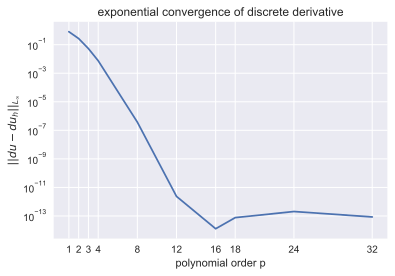

In [23]:
fig, ax = plt.subplots()
ax.semilogy(ps, errs)
ax.set_xticks(ps)
ax.set_ylabel(r'$||du - du_h||_{L_\infty}$')
ax.set_xlabel('polynomial order p')
ax.set_title('exponential convergence of discrete derivative')
plt.show()

# 1D master element

In `fem_base/master/nodal_basis_1D.py`, we define a simple nodal basis object for 1D problems -- no need to be fancy, pretty much the only thing we need this for is to get nodal shape functions and their derivatives efficiently. The underlying orthonormal Legendre polynomial basis is hidden to the user. This is the work horse for the master element.

In [24]:
# %load -s NodalBasis1D ../src/fem_base/master/nodal_basis_1D.py
class NodalBasis1D(object):
    """ minimalist nodal basis object:
    efficiently computes shape functions and their derivatives
    detailed explanation in tutorial/1D_basis_and_master_element.ipynb
    """
    def __init__(self, p, node_spacing='GAUSS_LOBATTO'):
        self.nb = p + 1
        if node_spacing == 'GAUSS_LOBATTO':
            self.nodal_pts, _ = LegendreGaussLobatto(self.nb)
        elif node_spacing == 'EQUIDISTANT':
            self.nodal_pts = np.linspace(-1, 1, self.nb)
        else: raise ValueError('node_spacing {} not recognized'.format(node_spacing))

    def shape_functions_at_pts(self, pts):
        """ computes shape functions evaluated at pts on [-1, 1]
        @retval shap (len(pts), nb) phi_j(pts[i])
        """
        V = p1d.Vandermonde1D(N=self.nb, x=self.nodal_pts)
        VTinv = np.linalg.inv(V.T)
        P = p1d.P_tilde(r=pts, N=self.nb)
        shap = np.dot(VTinv, P)
        return shap.T

    def shape_function_derivatives_at_pts(self, pts):
        """ computes shape function derivatives w/r/t x on [-1, 1]
        @retval shap_der, (Dr in Hesthaven), (len(pts), nb) d/dx phi_j(pts[i])
        """
        V  = p1d.Vandermonde1D(N=self.nb, x=self.nodal_pts)
        Vx = p1d.GradVandermonde1D(N=self.nb, x=pts)
        Vinv = np.linalg.inv(V)
        shap_der = np.dot(Vx, Vinv)
        return shap_der


Define a 1D master element, which is built on top of the 1D basis. 
- Precompute shape functions at the nodal points and Gauss Legendre quadrature points, both are useful for different types of schemes. We use Gauss Legendre points instead of Gauss Lobatto points because they can integrate degree $2n-1$ polynomials exactly instead of $2n - 3$, where $n$ is the number of integration points. We would like to integrate $(\phi_i, \phi_j)_{\hat{K}}$, which is order 2$p$, so to integrate the mass matrix exactly, we need $2p + 1$ points, and common practice is $2p+2$. Since quadrature in 1D is cheap, we opt for the latter.
- Precompute mass matrix $M_{ij} = (\phi_i, \phi_j)$ and stiffness matrices $S_{ij} = \left(\phi_i, \frac{d\phi_j}{dx}\right)$, $K_{ij} = \left(\frac{d\phi_i}{dx}, \frac{d\phi_j}{dx}\right)$. Additionally, store $M^{-1}$, as it is commonly used. Although Hesthaven's method for mass and stiffness matrices are elegant, they rely on the underlying choice of an orthanormal modal basis. Since this class could be overloaded to work with other choices of basis, better to simply compute these matrices with quadrature.

In [ ]:
# %load -s Master1D ../src/fem_base/master/master_1D.py
class Master1D(object):
    """ minimalist 1D master object, for use in purely 1D problems
    detailed explanation in tutorial/1D_basis_and_master_element.ipynb
    """
    def __init__(self, p, nquad_pts=None, *args, **kwargs):
        self.p, self.nb = p, p+1
        self.basis = NodalBasis1D(p=p, **kwargs)
        self.nodal_pts = self.basis.nodal_pts
        self.nq = 2*self.p + 2 if nquad_pts is None else nquad_pts
        self.quad_pts, self.wghts = GaussLegendre(self.nq)

        # shape functions at nodal and quadrature points
        self.shap_quad,  self.dshap_quad = self.mk_shap_and_dshap_at_pts(self.quad_pts)

        # mass, stiffness matrices
        self.M, self.S, self.K = self.mk_M(), self.mk_S(), self.mk_K()
        self.Minv = np.linalg.inv(self.M)

        # lifting permuatation matrix L (0s, 1s)
        self.L = self.mk_L()

    def mk_shap_and_dshap_at_pts(self, pts):
        shap = self.basis.shape_functions_at_pts(pts)
        dshap = self.basis.shape_function_derivatives_at_pts(pts)
        return shap, dshap

    def mk_M(self):
        """ the mass matrix, M_ij = (phi_i, phi_j) """
        shapw = np.dot(np.diag(self.wghts), self.shap_quad)
        M = np.dot(self.shap_quad.T, shapw)
        return M

    def mk_S(self):
        """ the stiffness matrix, S_ij = (phi_i, \frac{d\phi_j}{dx}) """
        dshapw = np.dot(np.diag(self.wghts), self.dshap_quad)
        S = np.dot(self.shap_quad.T, dshapw)
        return S

    def mk_K(self):
        """ the stiffness matrix, K_ij = (\frac{d\phi_i}{dx}, \frac{d\phi_j}{dx}) """
        dshapw = np.dot(np.diag(self.wghts), self.dshap_quad)
        K = np.dot(self.dshap_quad.T, dshapw)
        return K

    def mk_L(self):
        L = np.zeros((self.nb, 2))
        L[0, 0]  = 1
        L[-1, 1] = 1
        return L

    @property
    def shap_der(self):
        """ return the shape derivatives for apps expecting 2, 3D"""
        return [self.dshap_quad]


In [37]:
p=2
m1d = Master1D(p=p)
print(m1d.S)

m2 = mkm.Master_nodal(order=p, dim=1, element=0)
print(m2.K[0])

[[-5.00000000e-01  6.66666667e-01 -1.66666667e-01]
 [-6.66666667e-01 -8.40647907e-17  6.66666667e-01]
 [ 1.66666667e-01 -6.66666667e-01  5.00000000e-01]]
[[-5.00000000e-01 -6.66666667e-01  1.66666667e-01]
 [ 6.66666667e-01 -1.82500513e-17 -6.66666667e-01]
 [-1.66666667e-01  6.66666667e-01  5.00000000e-01]]


# TODO
- demonstration of lifting operator on master
- performance timings for creation of these base operators